# Next day energy prediction

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)


import xlrd
from datetime import datetime

In [ ]:
import ultil as ut
import process_ML as pm

In [ ]:
weather = pd.read_parquet('../Weather.parquet')
weather = ut.col_to_datetime(weather, '%time', index_time=True,type='xlrd', drop=True)
weather.dropna(inplace=True)

In [ ]:
resource = pd.read_parquet('../Resources.parquet')
resource = ut.col_to_datetime(resource, '%Time ', index_time=True, type='xlrd', drop=True)

In [ ]:
resource.head()

,Heat_cons,ElecHigh,ElecLow,CO2_cons,Irr,Drain
%Time,,,,,,
2019-12-16,2.19,0.7,0.0,0.009824,0.2,0.0
2019-12-17,0.92,0.8,0.6,0.015908,0.0,0.0
2019-12-18,1.26,0.9,0.6,0.014698,0.0,0.0
2019-12-19,0.75,0.8,0.6,0.023630,0.1,0.0
2019-12-20,0.84,1.4,0.6,0.021622,0.1,0.0


<AxesSubplot:xlabel='%Time '>

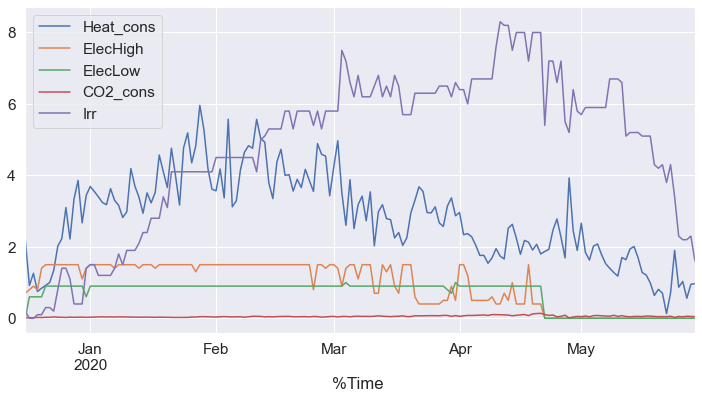

In [ ]:
sns.set(font_scale=1.4)
resource.iloc[:,0:5].plot(figsize=(12,6))

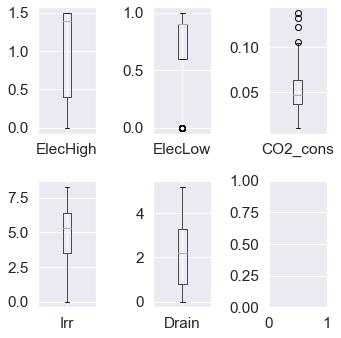

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(5, 5)) # create figure and axes
for i,el in enumerate(list(resource.iloc[:,1:].columns.values)):
    a = resource.boxplot(column=[el], ax=axes.flatten()[i])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='%time'>

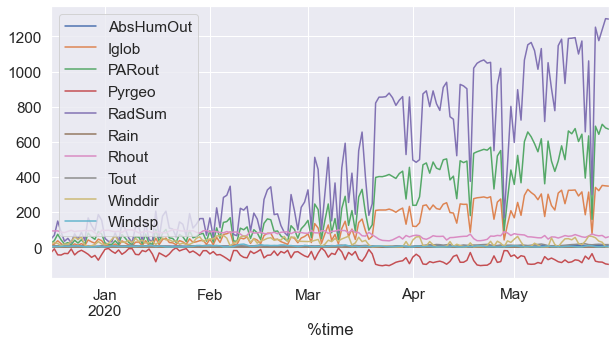

In [ ]:
weather_day = weather.resample('D').mean()
weather_day.plot(figsize=(10,5))

## Preprocess & feature engineering

In [ ]:
data = pd.concat([resource, weather_day], axis=1)
data['ElecAll'] = data['ElecHigh'] + data['ElecLow']
data = pm.time_features(data)
Target = data['ElecAll']
features = data.drop(['ElecAll', 'ElecHigh', 'ElecLow'], axis=1)

<AxesSubplot:>

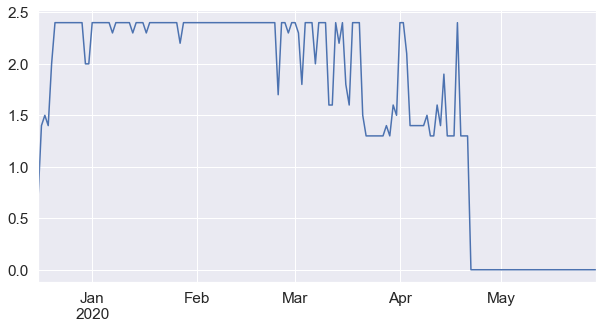

In [ ]:
data['ElecAll'].plot(figsize=(10,5))

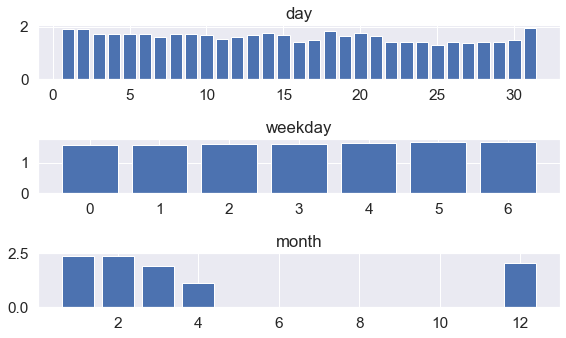

In [ ]:

nrows, ncols = 3,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(8,5))

for i, col in enumerate(['day','weekday','month']):
    
    plot_data = data.groupby(col)['ElecAll'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

There is more electricity consumption during winter months

## features scaling


In [ ]:
features.drop(columns=['hour'], inplace=True)
features_scaled = pm.scaling_features(features, features.columns.to_list()[:-3])

## Examine stationary of time series

In [ ]:
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()


/Users/pattama/.pyenv/versions/3.8.5/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


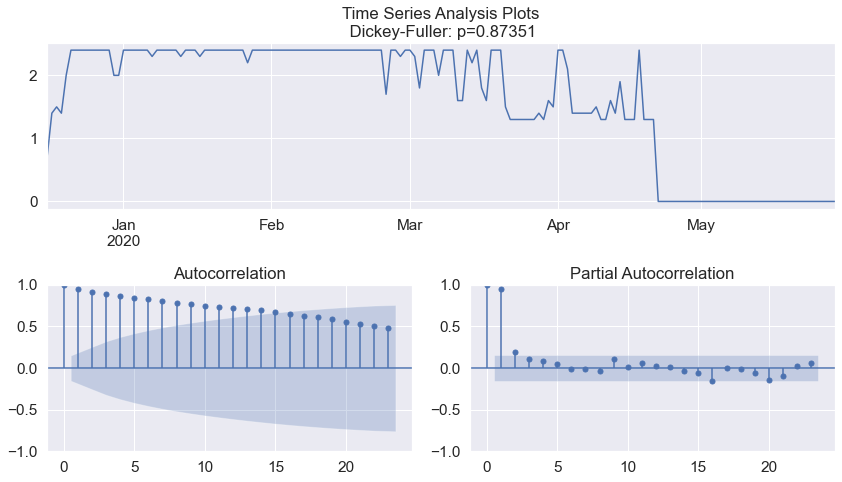

In [ ]:
tsplot(Target)

/Users/pattama/.pyenv/versions/3.8.5/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


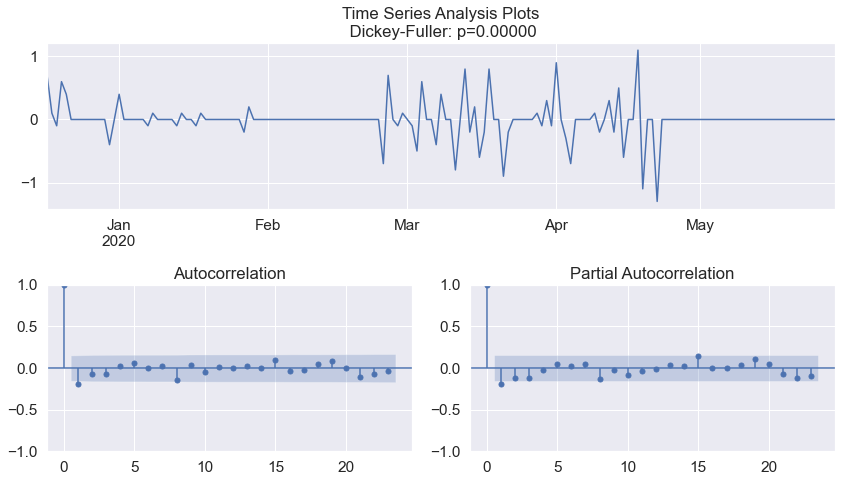

In [ ]:
elec_diff = (Target - Target.shift(1)).dropna()
tsplot(elec_diff)

The initial series are not stationary and the "seasonal difference" is stationary

## Decompose time series data into trend, seasonality and noise

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_timeseries(target_series, samples=250, period=None):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(target_series.values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(target_series.values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

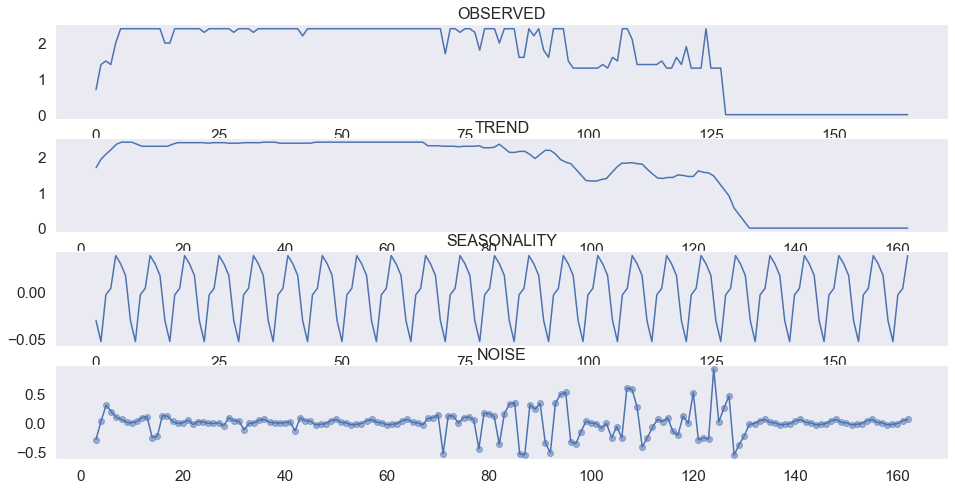

In [ ]:
decompose_timeseries(Target, samples='all', period=7)

My plan to do if I have more time is 
1. Creating linear regression model to predict energy consumption using features from weather data
2. Using time series model to predict all (next day) features in weather data
3. Use the model from step 1 and predicted (next day) features from step2 to predict energy consumption